In [2]:
import os,sys,time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from astropy.table import Table
warnings.filterwarnings("ignore")
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from scipy import interpolate
from scipy import integrate
from astropy import constants as const
from astropy import units as u

In [26]:
# Here are some functions to set the plots
def set_mpl_style(fsize=15, tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0):
    """Function to set MPL style"""

    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['ytick.right'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = major
    plt.rcParams['ytick.minor.size'] = minor
    plt.rcParams['xtick.major.width'] = lwidth
    plt.rcParams['xtick.minor.width'] = lwidth
    plt.rcParams['ytick.major.width'] = lwidth
    plt.rcParams['ytick.minor.width'] = lwidth
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    return

set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)

def get_levels(count_arr, quantile):
    values = np.ravel(count_arr)
    isoprop = np.asarray(quantile)
    sorted_values = np.sort(values)[::-1]
    normalized_values = np.cumsum(sorted_values) / values.sum()
    idx = np.searchsorted(normalized_values, 1 - isoprop)
    arr = np.take(sorted_values, idx, mode="clip")
    return arr


In [7]:
# Read the VACs

# SDSS DR16Q
sdss4_cat = fits.getdata('/data3/qiaoya/qsofit/sdss4/catalog/dr16q_prop_May01_2024.fits.gz', 1)
# SDSS DR19Q
sdss5_cat = fits.getdata('/data3/qiaoya/qsofit/sdss5/DR19/compilation/sdss5_dr19_Apr11_v613.fits', 1)

In [27]:
Table(sdss5_cat)

FIELD,MJD,CATALOGID,FITS_FILE,VERSION,RA,DEC,NEXP,EXPTIME,PROGRAMNAME,SURVEY,Z_PIPE,FIRSTCARTON,OBJTYPE,CLASS,SUBCLASS,VI_REMARK,Z_VI,Z_FIT,Z_SYS,Z_SYS_ERR,SN_RATIO_CONTI,EBV,CONTI_PARA,CONTI_PARA_ERR,FE_UV_PARA,FE_UV_PARA_ERR,FE_OP_PARA,FE_OP_PARA_ERR,LOGL1350,LOGL1350_ERR,LOGL1700,LOGL1700_ERR,LOGL2500,LOGL2500_ERR,LOGL3000,LOGL3000_ERR,LOGL4200,LOGL4200_ERR,LOGL5100,LOGL5100_ERR,CONTI_NPIX,FRAC_HOST_4200,FRAC_HOST_5100,DN4000,HOST_DECOMP_PARA,HALPHA,HALPHA_ERR,HALPHA_BR,HALPHA_BR_ERR,HALPHA_NA,HALPHA_NA_ERR,NII6549,NII6549_ERR,NII6585,NII6585_ERR,SII6718,SII6718_ERR,SII6732,SII6732_ERR,HBETA,HBETA_ERR,HBETA_BR,HBETA_BR_ERR,HEII4687,HEII4687_ERR,HEII4687_BR,HEII4687_BR_ERR,OIII5007,OIII5007_ERR,OIII5007C,OIII5007C_ERR,OIII4960,OIII4960_ERR,OIII4960C,OIII4960C_ERR,HGAMMA,HGAMMA_ERR,HDELTA,HDELTA_ERR,CAII3934,CAII3934_ERR,OII3728,OII3728_ERR,NEV3426,NEV3426_ERR,MGII,MGII_ERR,MGII_BR,MGII_BR_ERR,CIII_BR,CIII_BR_ERR,SIIII1892,SIIII1892_ERR,ALIII1857,ALIII1857_ERR,NIII1750,NIII1750_ERR,CIV,CIV_ERR,HEII1640,HEII1640_ERR,HEII1640_BR,HEII1640_BR_ERR,SIIV_OIV,SIIV_OIV_ERR,OI1304,OI1304_ERR,LYA,LYA_ERR,NV1240,NV1240_ERR,Ha_STAT,Hb_STAT,Hr_STAT,Hd_STAT,MgII_STAT,CIII_STAT,CIV_STAT,SiIV_STAT,Lya_STAT,CaII_STAT,OII_STAT,NeV_STAT,LOGLBOL,LOGLBOL_ERR,LOGMBH_HB,LOGMBH_HB_ERR,LOGMBH_MGII,LOGMBH_MGII_ERR,LOGMBH_CIV,LOGMBH_CIV_ERR,LOGMBH,LOGMBH_ERR,LOGLLEDD_RATIO,LOGLLEDD_RATIO_ERR,ZSYS_BEST,ZSYS_BEST_ERR,ZSYS_WEIGHT,ZSYS_WEIGHT_ERR,ZSYS_LINES,ZSYS_LINES_ERR
int64,int64,int64,str40,str40,float64,float64,int64,float64,str14,str13,float64,str48,str16,str6,str21,str12,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[3],float64[3],float64[3],float64[3],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[6],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64[2],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[8],float64[8]
15342,59328,5178567892,015342-59328-5178567892,v6_1_3,264.15295,5.8766738,5,4500.0,MWM_30min4,mwm-bhm,0.7100690603256226,bhm_gua_bright,QSO,QSO,BROADLINE,,-1.0,0.71006906,0.71006906,-1.0,7.137793762039086,0.0878130382343944,6.848464573216972 .. 0.0007151953689483,1.0672726258320608 .. 0.0002389777324534,0.0 .. 0.0,0.0 .. 0.0,1.0950457207670183 .. 0.0045606948124386,0.3732379405541053 .. 0.0021275142183766,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.76015336844755,0.0273882528905744,44.77320402684053,0.0344052338181057,2210.0,0.2297318167293708,0.2257062971525569,1.2630651744824348,0.6902975205681087 .. 0.7501534278696886,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,0.0 .. 0.0,-1.0 .. -1.0,4862.553707114385 .. 4862.264436372341,0.3785196306230318 .. 0.0815461588208563,4859.191517858816 .. 4865.5384101468,3.3456433700248454 .. 3.835174256374557,4686.275629328655 .. 4686.649657092268,0.3216928132083012 .. 0.117055455667014,4663.64141664896 .. 4666.527731969736,15.448659441904056 .. 15.371624010489995,5008.124089697561 .. 5007.701810623061,0.326831753036

In [8]:
# Remove objects with no redshift or potentially problematic values

ind_dr16 = np.where((sdss4_cat.Z_SYS>0)&(sdss4_cat.LOGLBOL>0)&(sdss4_cat.LOGMBH>0), True, False)
print('Number of objects in DR16:', len(sdss4_cat[ind_dr16]),'/', len(sdss4_cat))
ind_dr19 = np.where((sdss5_cat.Z_SYS>0)&(sdss5_cat.LOGLBOL>0)&(sdss5_cat.LOGMBH>0), True, False)
print('Number of objects in DR19:', len(sdss5_cat[ind_dr19]),'/', len(sdss5_cat))

Number of objects in DR16: 746268 / 750414
Number of objects in DR19: 81397 / 82363


In [9]:
# Values for contour plots: 1-, 2-, 3-sigma

data_percentile = np.array([0.003, 0.05, 0.32])

(43.0, 48.0)

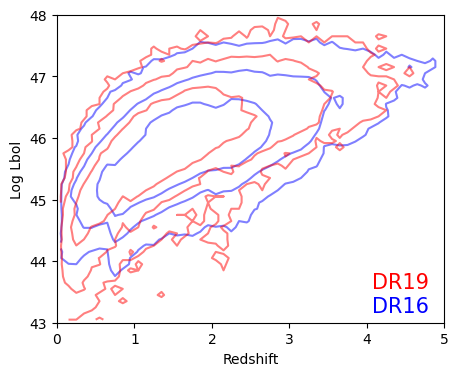

In [21]:
# Bolometric luminosity vs redshift

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
counts_dr16, xbins_dr16, ybins_dr16 = np.histogram2d(sdss4_cat.Z_SYS[ind_dr16], sdss4_cat.LOGLBOL[ind_dr16], 
                                        range=((0, 5), (43, 48)), bins=50)
counts_dr19, xbins_dr19, ybins_dr19 = np.histogram2d(sdss5_cat.Z_SYS[ind_dr19], sdss5_cat.LOGLBOL[ind_dr19],
                                        range=((0, 5), (43, 48)), bins=50) 
xmesh_dr16, ymesh_dr16 = np.meshgrid((xbins_dr16[:-1] + xbins_dr16[1:]) / 2, (ybins_dr16[:-1] + ybins_dr16[1:]) / 2)
xmesh_dr19, ymesh_dr19 = np.meshgrid((xbins_dr19[:-1] + xbins_dr19[1:]) / 2, (ybins_dr19[:-1] + ybins_dr19[1:]) / 2)
levels_dr16 = get_levels(counts_dr16, data_percentile)
levels_dr19 = get_levels(counts_dr19, data_percentile)
ax.contour(xmesh_dr16, ymesh_dr16, counts_dr16.T, levels=levels_dr16, colors='blue', alpha=0.5, label='DR16')
ax.contour(xmesh_dr19, ymesh_dr19, counts_dr19.T, levels=levels_dr19, colors='red', alpha=0.5, label='DR19')
ax.text(4.8, 43.1, 'DR16', color='blue', fontsize=15, ha='right', va='bottom')
ax.text(4.8, 43.5, 'DR19', color='red', fontsize=15, ha='right', va='bottom') 
ax.set_xlabel('Redshift')
ax.set_ylabel('Log Lbol')
ax.set_xlim(0, 5)
ax.set_ylim(43, 48)

(6.0, 11.0)

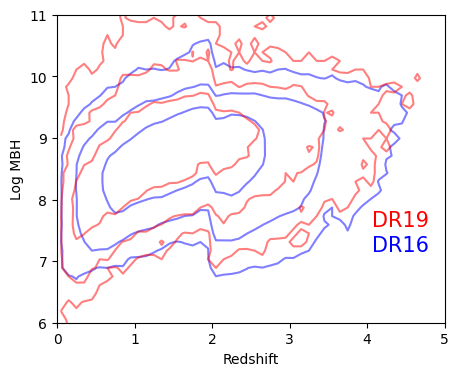

In [22]:
# MBH vs redshift
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
counts_dr16, xbins_dr16, ybins_dr16 = np.histogram2d(sdss4_cat.Z_SYS[ind_dr16], sdss4_cat.LOGMBH[ind_dr16], 
                                        range=((0, 5), (5, 12)), bins=50)
counts_dr19, xbins_dr19, ybins_dr19 = np.histogram2d(sdss5_cat.Z_SYS[ind_dr19], sdss5_cat.LOGMBH[ind_dr19],
                                        range=((0, 5), (5, 12)), bins=50)   
xmesh_dr16, ymesh_dr16 = np.meshgrid((xbins_dr16[:-1] + xbins_dr16[1:]) / 2, (ybins_dr16[:-1] + ybins_dr16[1:]) / 2)
xmesh_dr19, ymesh_dr19 = np.meshgrid((xbins_dr19[:-1] + xbins_dr19[1:]) / 2, (ybins_dr19[:-1] + ybins_dr19[1:]) / 2)
levels_dr16 = get_levels(counts_dr16, data_percentile)
levels_dr19 = get_levels(counts_dr19, data_percentile)
ax.contour(xmesh_dr16, ymesh_dr16, counts_dr16.T, levels=levels_dr16, colors='blue', alpha=0.5, label='DR16')
ax.contour(xmesh_dr19, ymesh_dr19, counts_dr19.T, levels=levels_dr19, colors='red', alpha=0.5, label='DR19')
ax.text(4.8, 7.1, 'DR16', color='blue', fontsize=15, ha='right', va='bottom')
ax.text(4.8, 7.5, 'DR19', color='red', fontsize=15, ha='right', va='bottom')
ax.set_xlabel('Redshift')
ax.set_ylabel('Log MBH')
ax.set_xlim(0, 5)
ax.set_ylim(6, 11)

# Note that the break at z~2 is due to the change from MgII to CIV emission line

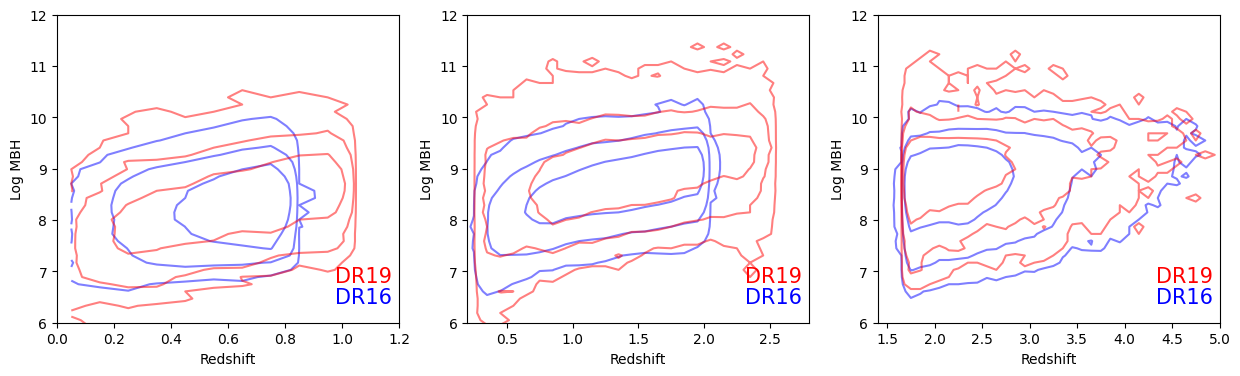

In [ ]:
# MBH vs redshift
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
z_range = [[0, 1.2], [0.2, 2.8], [1.4, 5]]
for i, line in enumerate(['HB', 'MGII', 'CIV']):
    counts_dr16, xbins_dr16, ybins_dr16 = np.histogram2d(sdss4_cat.Z_SYS[ind_dr16], sdss4_cat['LOGMBH_'+line][ind_dr16], 
                                            range=((0, 5), (5, 12)), bins=50)
    counts_dr19, xbins_dr19, ybins_dr19 = np.histogram2d(sdss5_cat.Z_SYS[ind_dr19], sdss5_cat['LOGMBH_'+line][ind_dr19],
                                            range=((0, 5), (5, 12)), bins=50)   
    xmesh_dr16, ymesh_dr16 = np.meshgrid((xbins_dr16[:-1] + xbins_dr16[1:]) / 2, (ybins_dr16[:-1] + ybins_dr16[1:]) / 2)
    xmesh_dr19, ymesh_dr19 = np.meshgrid((xbins_dr19[:-1] + xbins_dr19[1:]) / 2, (ybins_dr19[:-1] + ybins_dr19[1:]) / 2)
    levels_dr16 = get_levels(counts_dr16, data_percentile)
    levels_dr19 = get_levels(counts_dr19, data_percentile)
    ax[i].contour(xmesh_dr16, ymesh_dr16, counts_dr16.T, levels=levels_dr16, colors='blue', alpha=0.5, label='DR16')
    ax[i].contour(xmesh_dr19, ymesh_dr19, counts_dr19.T, levels=levels_dr19, colors='red', alpha=0.5, label='DR19')
    ax[i].text(0.98, 0.05, 'DR16', color='blue', fontsize=15, ha='right', va='bottom', transform=ax[i].transAxes)
    ax[i].text(0.98, 0.12, 'DR19', color='red', fontsize=15, ha='right', va='bottom', transform=ax[i].transAxes)
    ax[i].set_xlabel('Redshift')
    ax[i].set_ylabel('Log MBH')
    ax[i].set_xlim(z_range[i])
    ax[i].set_ylim(6, 12)